In [ ]:
%pip install plotnine

In [ ]:
import napari_skeleton_curator
from napari_skeleton_curator import (skeleton,
                                     measurements,
                                     utils)


import pandas as pd
import numpy as np
import napari
import ast
import networkx as nx
from plotnine import *


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable



In [ ]:
#function to create graph from data frame

NODE_COORDINATE_KEY = "node_coordinate"
EDGE_COORDINATES_KEY = "edge_coordinates"
EDGE_SPLINE_KEY = "edge_spline"
NODE_INDEX_KEY = "node_index"

EDGE_FEATURES_START_NODE_KEY = "start_node"
EDGE_FEATURES_END_NODE_KEY = "end_node"
EDGE_FEATURES_HIGHLIGHT_KEY = "highlight"


def data_frame_to_networkx(df,ID):
    """
    Converts a pandas DataFrame to a networkx graph.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to convert to networkx graph.

    Returns
    -------
    networkx.Graph
        Graph representation of the DataFrame.
    """
    G = nx.Graph()
    
    df = df[df['ID'] == ID]
    generation = 0
    max_generation = np.max(df['generation'])
    while generation  <= max_generation:
        edges_in_generation = df[df['generation'] == generation]
        for edge in edges_in_generation.iterrows():
            parent = edge[1]['parent_ID']
            if pd.isna(parent):
                parent = -1
            G.add_edge(parent, edge[1]['segment_ID'], **edge[1].to_dict())
            edge_coordinates = np.stack([ast.literal_eval(edge[1]['x']), ast.literal_eval(edge[1]['y']), ast.literal_eval(edge[1]['z'])], axis=1)
            G.edges[parent, edge[1]['segment_ID']][EDGE_COORDINATES_KEY] = edge_coordinates

            #add node coordinates
            G.nodes[parent][NODE_COORDINATE_KEY] = edge_coordinates[0]
            G.nodes[edge[1]['segment_ID']][NODE_COORDINATE_KEY] = edge_coordinates[-1]

            #add edge diameter

        generation += 1


    return G

In [3]:
#read in the data

#load data
df_control = pd.read_csv('/nas/groups/iber/Projects/Lung_Fractalization/Siemens_data/siemens_control.csv')


In [4]:
#for demo porpuses pick one Patient
df_control['ID'].unique()

array(['ChestAI_USB3046_1_3_centerine_processed.vtk',
       'ChestAI_USB3048_1_3_centerine_processed.vtk',
       'ChestAI_USB3049_1_3_centerine_processed.vtk',
       'ChestAI_USB3050_1_3_centerine_processed.vtk',
       'ChestAI_USB3051_1_3_centerine_processed.vtk',
       'ChestAI_USB3052_1_3_centerine_processed.vtk',
       'ChestAI_USB3054_2_3_centerine_processed.vtk',
       'ChestAI_USB3055_1_3_centerine_processed.vtk',
       'ChestAI_USB3056_2_3_centerine_processed.vtk',
       'ChestAI_USB3057_1_3_centerine_processed.vtk',
       'ChestAI_USB3058_1_3_centerine_processed.vtk',
       'ChestAI_USB3059_1_3_centerine_processed.vtk',
       'ChestAI_USB3060_1_3_centerine_processed.vtk',
       'ChestAI_USB3062_1_3_centerine_processed.vtk',
       'ChestAI_USB3063_2_3_centerine_processed.vtk',
       'ChestAI_USB3064_1_3_centerine_processed.vtk',
       'ChestAI_USB3066_1_3_centerine_processed.vtk',
       'ChestAI_USB3067_1_3_centerine_processed.vtk',
       'ChestAI_USB3068_1_3_

In [5]:
#get graph and compute some basic properties
G = data_frame_to_networkx(df_control,'ChestAI_USB3046_1_3_centerine_processed.vtk')

skeleton.compute_start_end_node(G, -1)
skeleton.compute_level(G, -1)


In [6]:
#parse and add attributes
skeleton_obj = skeleton.Skeleton3D.parse(G)


for u,v,attr in G.edges(data =True):
    skeleton_obj.graph[u][v].update(attr)


In [7]:
#compute angle
#simple varient, just takes branch nodes into account
angle_df, middle_points, center_points =napari_skeleton_curator.measurements.compute_midline_branch_angle_branch_nodes(skeleton_obj.graph, -1)
#samples point along the splines
angle_df_spline, middle_points_spline, center_points_spline = napari_skeleton_curator.measurements.compute_midline_branch_angles(skeleton_obj.graph, -1, sample_distance=0.01)

/local0/anaconda3/envs/sandbox/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.
/local0/anaconda3/envs/sandbox/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.


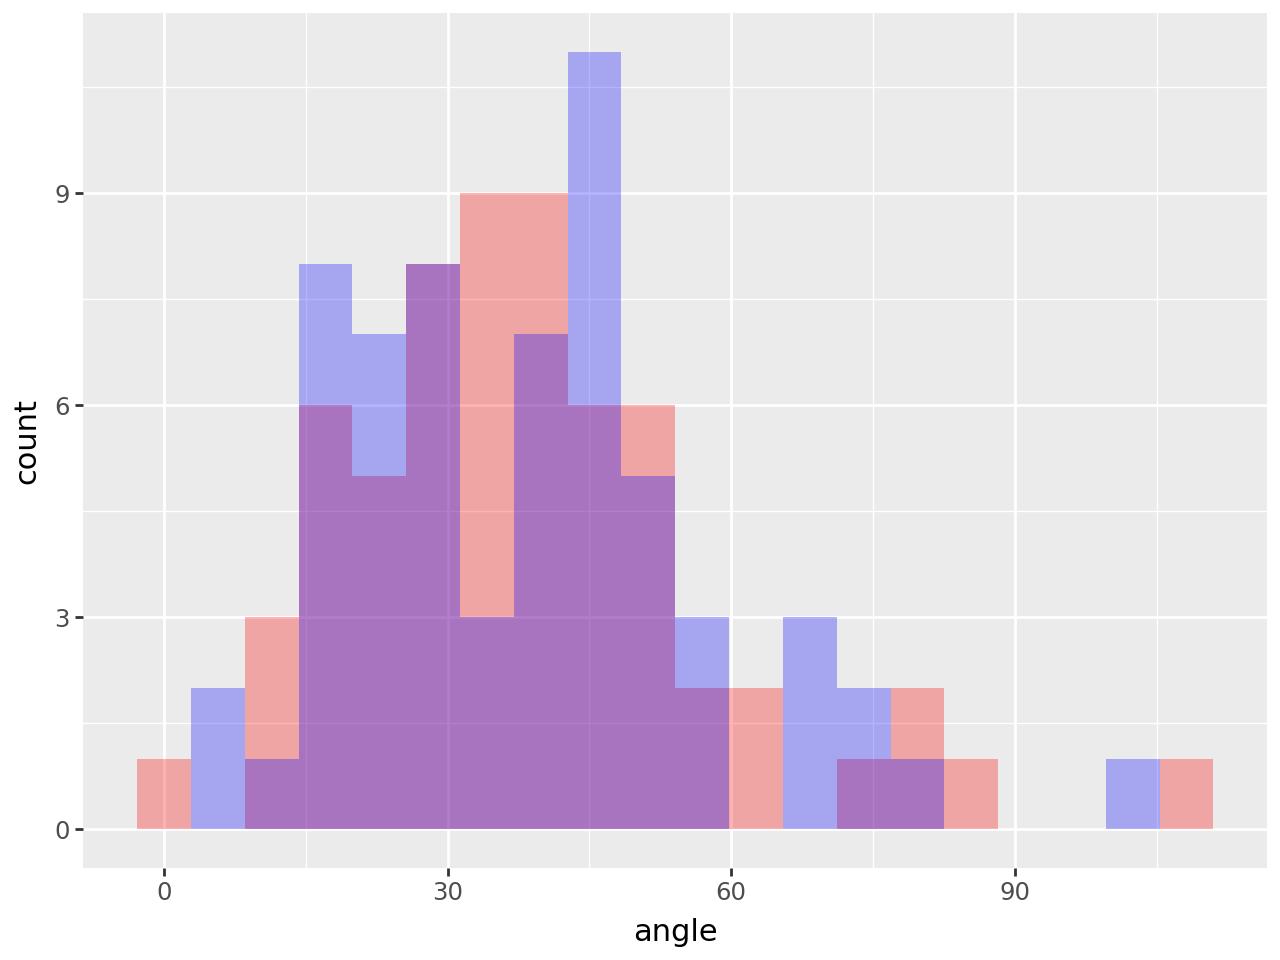

In [29]:
(ggplot(angle_df, aes("angle"))
+geom_histogram(fill = 'red', alpha = 0.3, bins = 20)
+geom_histogram(data = angle_df_spline, fill = 'blue', alpha = 0.3,bins = 20))

In [28]:
#viz in napari

viewer = napari.Viewer()

skeleton_viewer = skeleton.SkeletonViewer(skeleton = skeleton_obj, 
                                          viewer=viewer, 
                                          image = np.zeros((1,1,1)),
                                          # image = prediction,
                                            edge_width=3, 
                                            image_voxel_size=(1,1,1))


center_vector = [[center_points[i], middle_points[i]] for i in range(min(len(center_points), len(middle_points)))]
skeleton_viewer.viewer.add_shapes(data = center_vector, shape_type = 'path', edge_width = 2, edge_color = 'blue', name = 'midline')

center_vector = [[center_points_spline[i], middle_points_spline[i]] for i in range(min(len(center_points_spline), len(middle_points_spline)))]
skeleton_viewer.viewer.add_shapes(data = center_vector, shape_type = 'path', edge_width = 2, edge_color = 'pink', name = 'midline_all_spline')



initilize nodes
initilize edges


<Shapes layer 'midline_all_spline' at 0x7fa37c140f10>

In [63]:
#scale the color based on the angle.
#IN  THE GUI: make sure to select the nodes_layer, as otherwise the color gets overwritten again


skeleton_obj.graph.edges(data = True)

angle_dict = angle_df.set_index('edge')['angle'].to_dict()
nx.set_edge_attributes(skeleton_obj.graph, angle_dict, 'angle')





# Extract angles and edges
edges = list(angle_dict.keys())
angles = list(angle_dict.values())

# Normalize angles to range [0, 1] for colormap
norm = Normalize(vmin=np.nanmin(angles), vmax=np.nanmax(angles))

# Create Viridis colormap
cmap = plt.get_cmap('viridis')

# Assign colors based on normalized angles
colors = [cmap(norm(angle)) for angle in angles]
edge_color_dict = dict(zip(edges, colors))

skeleton_viewer.edges_layer.edge_color = colors


In [67]:
angle_df = measurements.add_parent_angles_to_df(G,angle_df, -1)

In [71]:
#murrays equation to minimize lumen volume and resistence
angle_df['parent_radius'] = angle_df['parent_diameter']/2
angle_df['radius'] = angle_df['diameter_filt']/2
nominator = angle_df['parent_radius']**4 + angle_df['radius']**4 - (angle_df['parent_radius']**3 - angle_df['radius']**3)**(4/3)
denominator = 2*angle_df['parent_radius']**2 * angle_df['radius']**2
angle_df['diameter_relationship_asymmetric'] = nominator/denominator

In [74]:
angle_df['cos_angle'] = np.cos(np.radians(angle_df['angle']))

/local0/anaconda3/envs/sandbox/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


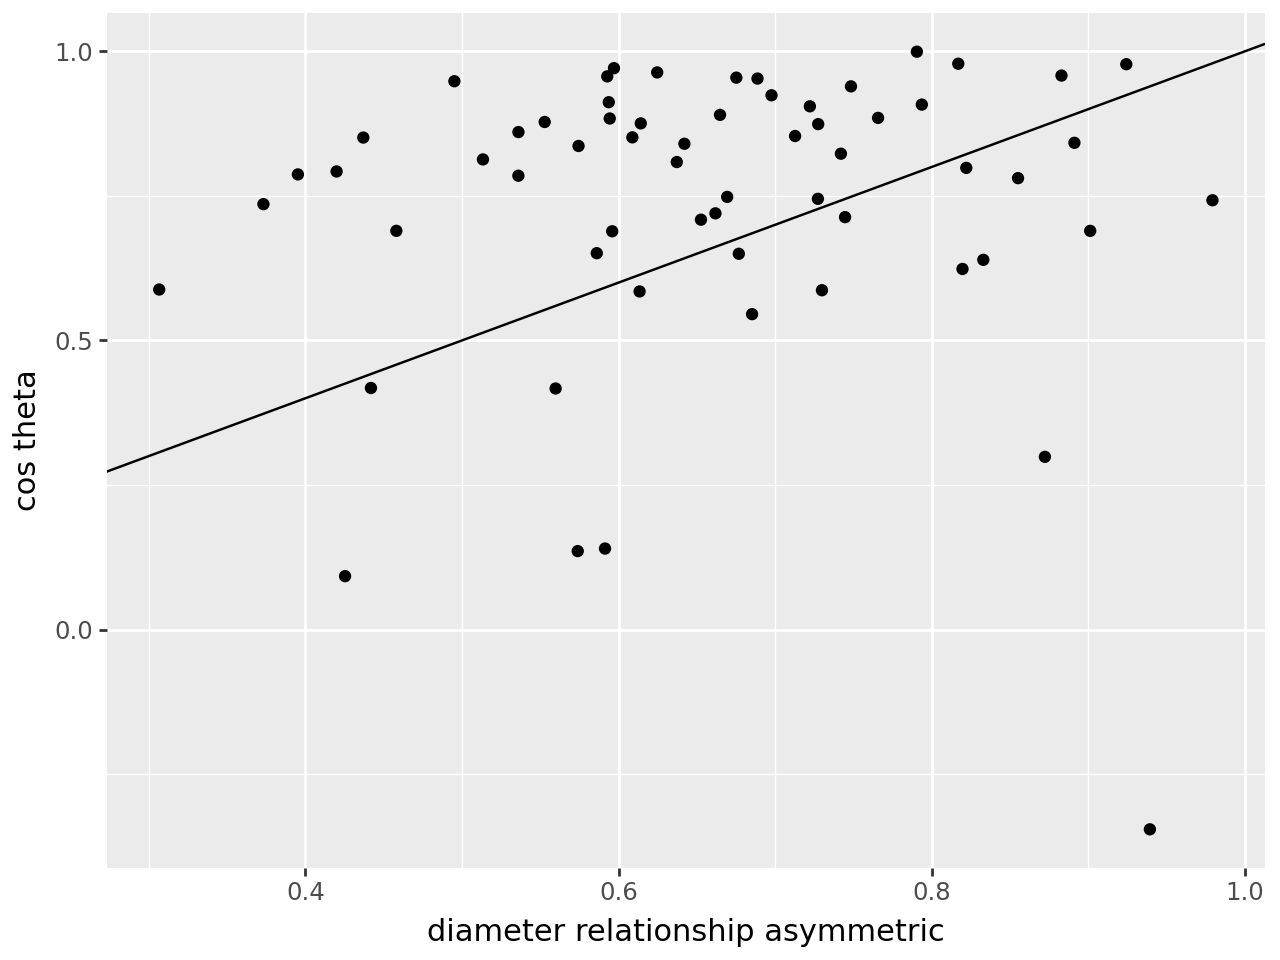

In [76]:
#ok relationship?

(ggplot(angle_df, aes('diameter_relationship_asymmetric', 'cos_angle')) + 
 geom_point()+
 theme(legend_position = 'none')+
   labs(x = 'diameter relationship asymmetric', y = 'cos theta')+

   geom_abline(slope = 1)
 )

In [79]:
#do it for all controls (3min runtime)

from napari_skeleton_curator.measurements import compute_midline_branch_angle_branch_nodes
angle_df_control = pd.DataFrame()
skeleton_obj_list_control = []
middle_point_list_control = []
center_point_list_control = []

for group_name, group_data in df_control.groupby('ID'):
    print(group_name)
    G = data_frame_to_networkx(df_control,group_data['ID'].values[0])
    skeleton.compute_branch_length(G)
    
    if -1 not in G.nodes:
        print('No root node found')
        continue

    skeleton.compute_start_end_node(G, -1)
    skeleton.compute_level(G, -1)

    skeleton_obj = skeleton.Skeleton3D.parse(G)


    for u,v,attr in G.edges(data =True):
        skeleton_obj.graph[u][v].update(attr)
    skeleton_obj_list_control.append(skeleton_obj)



    # angle_df, mps, cps = napari_skeleton_curator.measurements.compute_midline_branch_angles(skeleton_obj.graph, -1, sample_distance=0.1)
    angle_df, mps, cps = napari_skeleton_curator.measurements.compute_midline_branch_angle_branch_nodes(skeleton_obj.graph, -1)

    middle_point_list_control.append(mps)
    center_point_list_control.append(cps)
    angle_df = napari_skeleton_curator.measurements.add_parent_angles_to_df(G,angle_df, -1)
    angle_df['ID'] = group_name
    angle_df_control = pd.concat([angle_df_control, angle_df])


ChestAI_USB3046_1_3_centerine_processed.vtk
ChestAI_USB3048_1_3_centerine_processed.vtk
ChestAI_USB3049_1_3_centerine_processed.vtk
ChestAI_USB3050_1_3_centerine_processed.vtk
ChestAI_USB3051_1_3_centerine_processed.vtk
ChestAI_USB3052_1_3_centerine_processed.vtk
ChestAI_USB3054_2_3_centerine_processed.vtk
ChestAI_USB3055_1_3_centerine_processed.vtk
ChestAI_USB3056_2_3_centerine_processed.vtk
ChestAI_USB3057_1_3_centerine_processed.vtk
ChestAI_USB3058_1_3_centerine_processed.vtk
ChestAI_USB3059_1_3_centerine_processed.vtk
No root node found
ChestAI_USB3060_1_3_centerine_processed.vtk
ChestAI_USB3062_1_3_centerine_processed.vtk
ChestAI_USB3063_2_3_centerine_processed.vtk
ChestAI_USB3064_1_3_centerine_processed.vtk
ChestAI_USB3066_1_3_centerine_processed.vtk
ChestAI_USB3067_1_3_centerine_processed.vtk
ChestAI_USB3068_1_3_centerine_processed.vtk
ChestAI_USB3069_1_3_centerine_processed.vtk
ChestAI_USB3070_1_3_centerine_processed.vtk
ChestAI_USB3071_1_3_centerine_processed.vtk
ChestAI_USB30

In [81]:
angle_df = angle_df_control

#murrays equation to minimize lumen volume and resistence
angle_df['parent_radius'] = angle_df['parent_diameter']/2
angle_df['radius'] = angle_df['diameter_filt']/2
nominator = angle_df['parent_radius']**4 + angle_df['radius']**4 - (angle_df['parent_radius']**3 - angle_df['radius']**3)**(4/3)
denominator = 2*angle_df['parent_radius']**2 * angle_df['radius']**2
angle_df['diameter_relationship_asymmetric'] = nominator/denominator


angle_df['cos_angle'] = np.cos(np.radians(angle_df['angle']))

/local0/anaconda3/envs/sandbox/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 126 rows containing missing values.


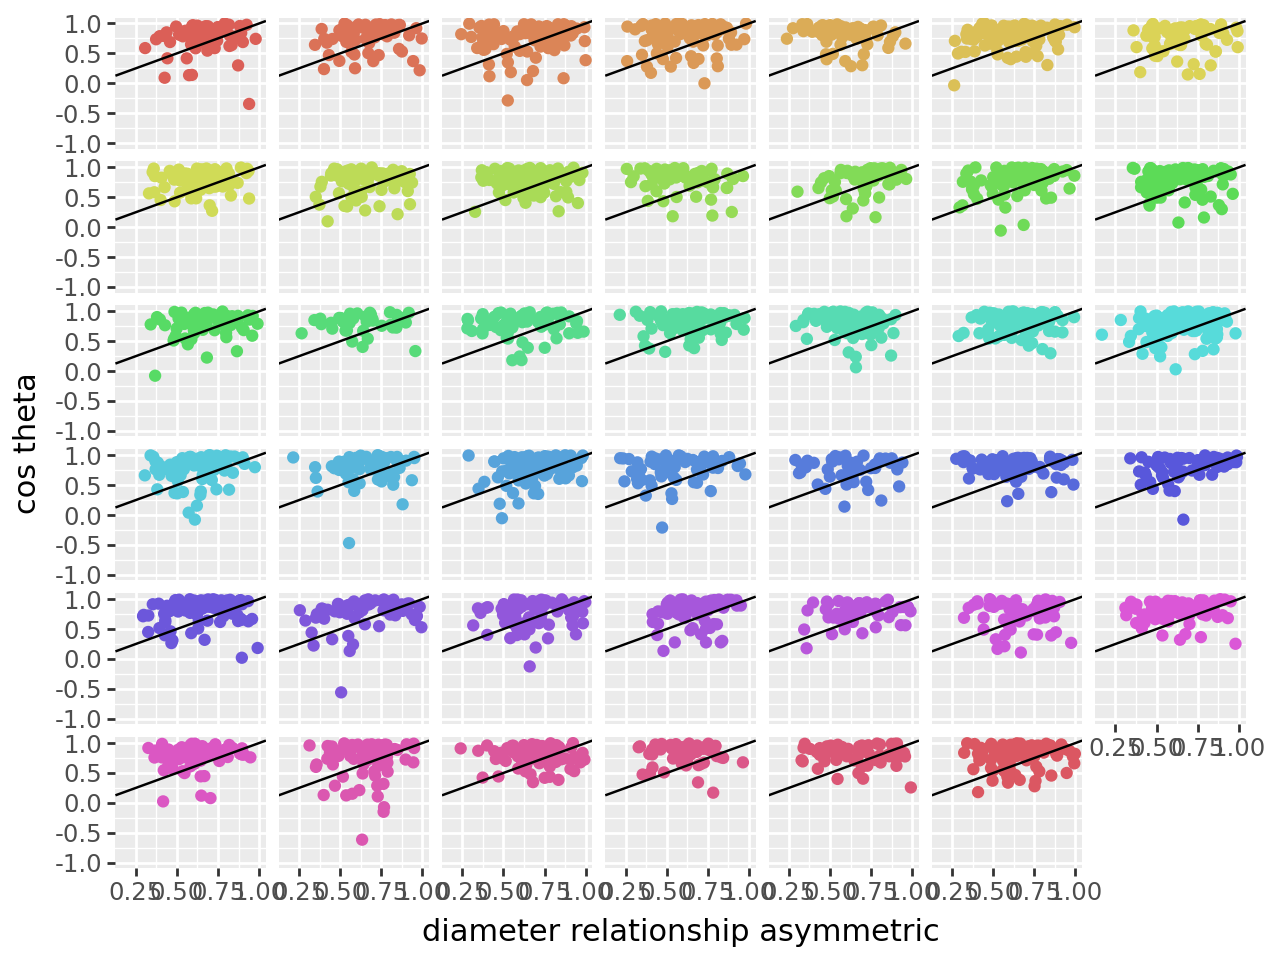

In [87]:
#drown in variability 
(ggplot(angle_df, aes('diameter_relationship_asymmetric', 'cos_angle', color = 'ID')) + 
 geom_point()+
 theme(legend_position = 'none')+
   labs(x = 'diameter relationship asymmetric', y = 'cos theta')+
   theme(strip_text = element_blank())+
   geom_abline(slope = 1)+
   facet_wrap('ID')
 )